## Preliminaries

### imports

In [1]:
from dicesapi import DicesAPI
import pandas as pd
import os

### global variables

In [2]:
input_file = os.path.join('data', 'input.xlsx')
sheet_name = 'with_repeated_lines'
output_dir = 'output'

### DICES connection

In [3]:
api = DicesAPI(logfile=os.path.join(output_dir, 'dices.log'))

### function definitions

In [4]:
def gender_all(insts):
    '''returns a simple gender label for a group of instances'''
    genders = '-'.join(sorted(set([inst.gender for inst in insts])))
    if len(genders) == 0:
        return None    
    
    if genders == 'male':
        return 'male'
    if genders == 'female':
        return 'female'
    
    return 'other'
    
def gender_first(insts):
    '''returns a gender label for the first instance of a group'''
    genders = [inst.gender for inst in insts]
    if len(genders) == 0:
        return None
        
    if genders[0] == 'male':
        return 'male'
    if genders[0] == 'female':
        return 'female'
    
    return 'other'

In [5]:
def being_all(insts):
    '''returns a simple being label for a group of instances'''
    beings = '-'.join(sorted(set([inst.being for inst in insts])))
    if len(beings) == 0:
        return None
    
    if beings == 'mortal':
        return 'mortal'
    if beings == 'divine':
        return 'divine'
    
    return 'other'
    
def being_first(insts):
    '''returns a being label for the first instance of a group'''
    beings = [inst.being for inst in insts]
    if len(beings) == 0:
        return None    
    
    if beings[0] == 'moral':
        return 'mortal'
    if beings[0] == 'divine':
        return 'divine'
    
    return 'other'

In [6]:
def speech_to_lines(speech):
    '''turn a speech into a pandas dataframe with one line per row'''

    if speech.l_fi.split('.')[0] != speech.l_la.split('.')[0]:
        if speech.l_fi == '9.2' and speech.l_la == '11.332':
            loci = [(9, line) for line in range(2, 333)]
            loci.extend([(10, line) for line in range(1, 575)])
            loci.extend([(11, line) for line in range(1, 333)])
        elif speech.l_fi == '11.378' and speech.l_la == '12.453':
            loci = [(11, line) for line in range(378, 641)]
            loci.extend([(12, line) for line in range(1, 454)])
        else:
            print(f"Can't process {speech}")
            loci = []
    else:
        book = int(speech.l_fi.split('.')[0])
        l_fi = int(speech.l_fi.split('.')[1])
        l_la = int(speech.l_la.split('.')[1])

        loci = [(book, line) for line in range(l_fi, l_la+1)]
    
    df = pd.DataFrame(dict(
        seq = speech.seq,
        work = speech.work.urn,
        book = book,
        line = line,
        from_first = i,
        from_last = i - len(loci) + 1,
        cluster = speech.cluster.id,
        part = speech.part,
        level = speech.level,
        spkr_first = speech.spkr[0].name,
        spkr_all = speech.getSpkrString(),
        spkr_gender_first = gender_first(speech.spkr),
        spkr_gender_all = gender_all(speech.spkr),
        spkr_being_first = being_first(speech.spkr),
        spkr_being_all = being_all(speech.spkr),
        addr_first = speech.addr[0].name,
        addr_all = speech.getAddrString(),
        addr_gender_first = gender_first(speech.addr),
        addr_gender_all = gender_all(speech.addr),
        addr_being_first = being_first(speech.addr),
        addr_being_all = being_all(speech.addr),
    ) for i, (book, line) in enumerate(loci))
    
    return df

## Data

### Homer speech data

In [7]:
hom_speeches = sorted(api.getSpeeches(work_title='Iliad') + api.getSpeeches(work_title='Odyssey'))
hom_df = pd.concat([speech_to_lines(s) for s in hom_speeches])
hom_df = hom_df.rename(columns={
            'work':'hom_work',
            'book':'hom_book',
            'line':'hom_line',
            'seq':'hom_seq',
            'from_first':'hom_from_first',
            'from_last':'hom_from_last',
            'cluster':'hom_cluster',
            'part':'hom_part',
            'level':'hom_level',
            'spkr_first':'hom_spkr_first',
            'spkr_all':'hom_spkr_all',    
            'spkr_gender_first':'hom_spkr_gender_first',
            'spkr_gender_all':'hom_spkr_gender_all',
            'spkr_being_first':'hom_spkr_being_first',
            'spkr_being_all':'hom_spkr_being_all',
            'addr_first':'hom_addr_first',
            'addr_all':'hom_addr_all',    
            'addr_gender_first':'hom_addr_gender_first',
            'addr_gender_all':'hom_addr_gender_all',
            'addr_being_first':'hom_addr_being_first',
            'addr_being_all':'hom_addr_being_all',
})

# where the same locus occurs in two speeches (i.e. embedding),
#  keep only the innermost (highest embedded level)
hom_df = hom_df.sort_values(by=['hom_work', 'hom_book', 'hom_line', 'hom_level']
              ).drop_duplicates(['hom_work', 'hom_book', 'hom_line'], keep='last')

### Eudocia speech data

In [8]:
eud_speeches = api.getSpeeches(work_title='Homerocentones')
eud_df = pd.DataFrame(dict(
    eud_seq = s.seq,
    eud_cluster = s.cluster.id,
    eud_part = s.part,
    eud_first = int(s.l_fi),
    eud_last = int(s.l_la),
    eud_spkr_first = s.spkr[0].name,
    eud_spkr_all = s.getSpkrString(),
    eud_spkr_gender_first = gender_first(s.spkr),
    eud_spkr_gender_all = gender_all(s.spkr),
    eud_spkr_being_first = being_first(s.spkr),
    eud_spkr_being_all = being_all(s.spkr),
    eud_addr_first = s.addr[0].name,
    eud_addr_all = s.getAddrString(),
    eud_addr_gender_first = gender_first(s.addr),
    eud_addr_gender_all = gender_all(s.addr),
    eud_addr_being_first = being_first(s.addr),
    eud_addr_being_all = being_all(s.addr),
) for s in eud_speeches)

### source lines for cento

In [9]:
cento_df = pd.read_excel(input_file, 
            sheet_name=sheet_name, 
            usecols=[0,1,2,3,4,5,6],
            keep_default_na=False,
            )
cento_df.loc[cento_df.hom_work=='Il.','hom_work'] = 'urn:cts:greekLit:tlg0012.tlg001.perseus-grc2'
cento_df.loc[cento_df.hom_work=='Od.','hom_work'] = 'urn:cts:greekLit:tlg0012.tlg002.perseus-grc2'

### add speaker, addressee info from eud_speeches

In [10]:
df = pd.merge(cento_df, eud_df, how='left', on='eud_seq')

In [11]:
# calculate distance from beginning, end of speeches
df['eud_from_first'] = df.eud_line - df.eud_first
df['eud_from_last'] = df.eud_line - df.eud_last
df = df.drop(columns=['eud_first', 'eud_last'])

### add speaker, addressee info from hom_speeches

In [12]:
joint_df=pd.merge(df, hom_df, how='left', on=['hom_work', 'hom_book', 'hom_line'])

### label narrator text in Homer

In [13]:
mask = joint_df.hom_spkr_all.isna() & joint_df.hom_line.notna()
joint_df.loc[mask, 'hom_spkr_all'] = 'Narrator'
joint_df.loc[mask, 'hom_spkr_first'] = 'Narrator'
joint_df.loc[mask, 'hom_spkr_gender_all'] = 'Narrator'
joint_df.loc[mask, 'hom_spkr_gender_first'] = 'Narrator'
joint_df.loc[mask, 'hom_spkr_being_all'] = 'Narrator'
joint_df.loc[mask, 'hom_spkr_being_first'] = 'Narrator'
joint_df.loc[mask, 'hom_addr_all'] = 'Narrator'
joint_df.loc[mask, 'hom_addr_first'] = 'Narrator'
joint_df.loc[mask, 'hom_addr_gender_all'] = 'Narrator'
joint_df.loc[mask, 'hom_addr_gender_first'] = 'Narrator'
joint_df.loc[mask, 'hom_addr_being_all'] = 'Narrator'
joint_df.loc[mask, 'hom_addr_being_first'] = 'Narrator'

### simplify spkr columns

In [14]:
# in Eudocia and Homer there are no lines with multiple speakers
#  - that means we can simplify the columns structure significantly

if pd.Series.all(joint_df.hom_spkr_all == joint_df.hom_spkr_first):
    joint_df = joint_df.drop(columns = [
        'eud_spkr_all', 'eud_spkr_gender_all', 'eud_spkr_being_all',
        'hom_spkr_all', 'hom_spkr_gender_all', 'hom_spkr_being_all',
    ])
    joint_df = joint_df.rename(columns={
        'eud_spkr_first':'eud_spkr',
        'eud_spkr_gender_first':'eud_spkr_gender',
        'eud_spkr_being_first':'eud_spkr_being',
        'hom_spkr_first':'hom_spkr',
        'hom_spkr_gender_first':'hom_spkr_gender',
        'hom_spkr_being_first':'hom_spkr_being',
    })
else:
    print("Can't simplify columns: found multiple speakers!")

### write output

In [15]:
hom_df.to_csv(os.path.join(output_dir, 'homer.csv'), index=False)
eud_df.to_csv(os.path.join(output_dir, 'eudocia.csv'), index=False)
joint_df.to_csv(os.path.join(output_dir, 'output.csv'), index=False)

## sample calculations

<AxesSubplot:ylabel='hom_spkr_gender'>

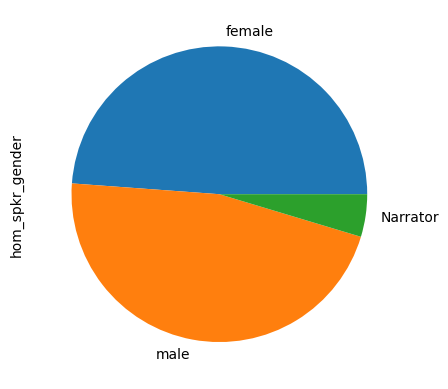

In [16]:
joint_df.loc[joint_df.eud_spkr=='Maria','hom_spkr_gender'].value_counts().plot.pie()